In [ ]:
import numpy as np
import pandas as pd
from rdkit import DataStructs
from rdkit.Chem.rdmolfiles import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import PandasTools
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import gc
from sklearn.model_selection import train_test_split

In [ ]:
def calcfp(mol,funcFPInfo=dict(radius=3,nBits=2048,useFeatures=False,useChirality = False)):
    arr = np.zeros((1,))
    fp = GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [ ]:
seed = 42

In [ ]:
train = pd.read_csv('train_data.txt', sep='\t')
train = train.rename(columns={'Smiles String': 'Smiles', 'agg' : 'label'})

test_agg = pd.read_csv('agg_data_test.txt', sep='\t')
test_agg['label']='AGG'
test_agg.drop('ID', axis=1, inplace = True)

test_non_agg= pd.read_csv('nonagg_data_test.txt', sep='\t')
test_non_agg['label']='NONAGG'
test_non_agg.drop('ID', axis=1, inplace = True)

data = pd.concat([test_agg, test_non_agg, train], ignore_index=True)

data = data.rename(columns={'label': 'labels','Smiles' : 'smiles' })

label_map = {
    'AGG': 1,
    'NONAGG': 0,
}

data = data.drop('Unnamed: 0', axis=1 )
data['labels'] = data['labels'].map(label_map)
data.dropna(inplace=True)

In [ ]:
train_df1, test_df1 = train_test_split(data, test_size=0.2, random_state = seed, stratify=data['labels'])
train_df1, valid_df1 = train_test_split(train_df1, test_size=0.2, random_state = seed,  stratify=train_df1['labels'])

In [ ]:
majority_class = train_df1[train_df1['labels'] == 0]
minority_class = train_df1[train_df1['labels'] == 1]

majority_undersampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state = seed)

train_df1 = pd.concat([minority_class, majority_undersampled])

In [ ]:
# Add Mol column
PandasTools.AddMoleculeColumnToFrame(train_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
moldf = train_df1[pd.notnull(train_df1['Mol'])]

moldf['Descriptors'] = moldf.Mol.apply(calcfp)
X = np.array(list(moldf['Descriptors'])).astype(int)
y = moldf['labels'].to_numpy()

## Preparing model

In [ ]:
class Data(Dataset):
  def __init__(self, X, y):
    self.X = torch.from_numpy(X.astype(np.float32))
    self.y = torch.from_numpy(y).type(torch.LongTensor)
    self.len = self.X.shape[0]

  def __getitem__(self, index):
    return self.X[index], self.y[index]
  def __len__(self):
    return self.len

In [ ]:
traindata = Data(X, y)

In [ ]:
class BinaryClassificationModel(nn.Module):
    def __init__(self, input_size=2048, num_units=1000):
        super(BinaryClassificationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, num_units)
        self.fc2 = nn.Linear(num_units, num_units)
        self.fc3 = nn.Linear(num_units, num_units)
        self.fc4 = nn.Linear(num_units, num_units)
        self.fc5 = nn.Linear(num_units, num_units)
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.1)
        self.output_layer = nn.Linear(num_units, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.dropout2(x)
        x = self.fc5(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x

# Hyperparameters
fully_connected_layer_size = 1000
number_of_layers = 5
dropout_probability1 = 0.5
dropout_probability2 = 0.1
training_epochs = 100

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_loader = DataLoader(traindata, batch_size=50, shuffle=True)

# Loss function and optimizer
criterion = nn.BCELoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, train_loader):

        model.train()
        model.to(device)

        # Training loop
        for epoch in range(training_epochs):
            model.train()
            running_loss = 0.0

            for inputs, labels in train_loader:  # Iterate over your training data
                optimizer.zero_grad()  # Zero the parameter gradients
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                labels = labels.view(-1, 1).float()  # Ensure labels are of type float for BCELoss

                # Calculate the loss
                loss = criterion(outputs, labels)

                # Backpropagation and optimization
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            #print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

        print("Training finished")

## gridsearch

In [ ]:
from skorch import NeuralNetBinaryClassifier

net = NeuralNetBinaryClassifier(
    BinaryClassificationModel,
    module__input_size=2048,
    criterion=nn.BCELoss,
    optimizer=optim.SGD,
    max_epochs=10,
    lr=0.1,
    device = device
)

In [ ]:
param_grid = {
    #'module__input_size': [2048],
    'module__num_units': [500, 1000, 2000],
    'max_epochs': [10, 50, 100],
    'lr': [0.0001, 0.001, 0.01, 0.1]
}

In [ ]:
X = X.astype(np.float32)
y = y.astype(np.float32)

In [ ]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(net, param_grid, refit=False, cv=3, scoring='accuracy', error_score='raise')

gs.fit(X, y)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7061       0.3077        0.7054  0.0054
      2        0.7057       0.3077        0.7054  0.0054
      3        0.7065       0.3077        0.7054  0.0050
      4        0.7060       0.3077        0.7054  0.0047
      5        0.7055       0.3077        0.7053  0.0047
      6        0.7057       0.3077        0.7053  0.0045
      7        0.7059       0.3077        0.7053  0.0045
      8        0.7057       0.3077        0.7053  0.0046
      9        0.7067       0.3077        0.7053  0.0044
     10        0.7058       0.3077        0.7053  0.0046
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6900       0.6538        0.6903  0.0042
      2        0.6900       0.6538        0.6903  0.0046
      3        0.6906       0.6538        0.6903  0.0043
      4        0.6896       0.6

     12        0.6851       0.6923        0.6861  0.0044
     13        0.6853       0.6923        0.6861  0.0042
     14        0.6847       0.6923        0.6861  0.0044
     15        0.6852       0.6923        0.6861  0.0043
     16        0.6843       0.6923        0.6861  0.0043
     17        0.6847       0.6923        0.6861  0.0042
     18        0.6849       0.6923        0.6861  0.0040
     19        0.6850       0.6923        0.6861  0.0044
     20        0.6848       0.6923        0.6861  0.0042
     21        0.6856       0.6923        0.6861  0.0044
     22        0.6847       0.6923        0.6860  0.0042
     23        0.6847       0.6923        0.6860  0.0043
     24        0.6850       0.6923        0.6860  0.0042
     25        0.6849       0.6923        0.6860  0.0043
     26        0.6853       0.6923        0.6860  0.0044
     27        0.6850       0.6923        0.6860  0.0042
     28        0.6845       0.6923        0.6860  0.0044
     29        0.6848       0.6

     31        0.6998       0.3077        0.7006  0.0042
     32        0.6999       0.3077        0.7006  0.0044
     33        0.6998       0.3077        0.7006  0.0042
     34        0.6991       0.3077        0.7006  0.0045
     35        0.7000       0.3077        0.7006  0.0042
     36        0.7005       0.3077        0.7006  0.0042
     37        0.6993       0.3077        0.7006  0.0045
     38        0.7001       0.3077        0.7006  0.0043
     39        0.6994       0.3077        0.7005  0.0044
     40        0.6997       0.3077        0.7005  0.0041
     41        0.6995       0.3077        0.7005  0.0043
     42        0.6993       0.3077        0.7005  0.0042
     43        0.6999       0.3077        0.7005  0.0043
     44        0.7005       0.3077        0.7005  0.0044
     45        0.7006       0.3077        0.7005  0.0043
     46        0.6998       0.3077        0.7005  0.0044
     47        0.6999       0.3077        0.7005  0.0043
     48        0.7001       0.3

     50        0.6865       0.6923        0.6871  0.0047
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6869       0.6923        0.6862  0.0044
      2        0.6863       0.6923        0.6862  0.0048
      3        0.6865       0.6923        0.6862  0.0046
      4        0.6864       0.6923        0.6862  0.0048
      5        0.6865       0.6923        0.6862  0.0046
      6        0.6869       0.6923        0.6862  0.0047
      7        0.6865       0.6923        0.6862  0.0046
      8        0.6864       0.6923        0.6862  0.0046
      9        0.6860       0.6923        0.6861  0.0047
     10        0.6866       0.6923        0.6861  0.0046
     11        0.6872       0.6923        0.6861  0.0047
     12        0.6862       0.6923        0.6861  0.0047
     13        0.6864       0.6923        0.6861  0.0045
     14        0.6863       0.6923        0.6861  0.0048
     15        0.6865       0.6

     16        0.6907       0.6538        0.6910  0.0055
     17        0.6910       0.6538        0.6910  0.0055
     18        0.6911       0.6538        0.6910  0.0055
     19        0.6907       0.6538        0.6910  0.0055
     20        0.6914       0.6538        0.6909  0.0055
     21        0.6904       0.6538        0.6909  0.0055
     22        0.6909       0.6538        0.6909  0.0055
     23        0.6909       0.6538        0.6909  0.0056
     24        0.6909       0.6538        0.6909  0.0055
     25        0.6905       0.6538        0.6909  0.0055
     26        0.6911       0.6538        0.6909  0.0056
     27        0.6917       0.6538        0.6909  0.0055
     28        0.6908       0.6538        0.6909  0.0055
     29        0.6907       0.6538        0.6909  0.0056
     30        0.6907       0.6538        0.6908  0.0055
     31        0.6913       0.6923        0.6908  0.0055
     32        0.6911       0.6923        0.6908  0.0055
     33        0.6907       0.6

     35        0.6853       0.6923        0.6867  0.0044
     36        0.6853       0.6923        0.6867  0.0042
     37        0.6856       0.6923        0.6867  0.0044
     38        0.6849       0.6923        0.6867  0.0043
     39        0.6855       0.6923        0.6866  0.0043
     40        0.6851       0.6923        0.6866  0.0044
     41        0.6855       0.6923        0.6866  0.0044
     42        0.6846       0.6923        0.6866  0.0045
     43        0.6850       0.6923        0.6866  0.0043
     44        0.6846       0.6923        0.6866  0.0044
     45        0.6851       0.6923        0.6866  0.0043
     46        0.6849       0.6923        0.6866  0.0043
     47        0.6853       0.6923        0.6866  0.0047
     48        0.6845       0.6923        0.6866  0.0044
     49        0.6853       0.6923        0.6866  0.0045
     50        0.6842       0.6923        0.6866  0.0043
     51        0.6856       0.6923        0.6865  0.0044
     52        0.6852       0.6

     56        0.6821       0.6923        0.6827  0.0045
     57        0.6826       0.6923        0.6827  0.0045
     58        0.6819       0.6923        0.6827  0.0044
     59        0.6822       0.6923        0.6827  0.0042
     60        0.6820       0.6923        0.6827  0.0042
     61        0.6817       0.6923        0.6827  0.0043
     62        0.6825       0.6923        0.6827  0.0043
     63        0.6818       0.6923        0.6827  0.0044
     64        0.6834       0.6923        0.6827  0.0044
     65        0.6821       0.6923        0.6826  0.0047
     66        0.6827       0.6923        0.6826  0.0043
     67        0.6818       0.6923        0.6826  0.0043
     68        0.6817       0.6923        0.6826  0.0044
     69        0.6832       0.6923        0.6826  0.0043
     70        0.6820       0.6923        0.6826  0.0042
     71        0.6824       0.6923        0.6826  0.0044
     72        0.6821       0.6923        0.6826  0.0043
     73        0.6827       0.6

     78        0.6857       0.6923        0.6857  0.0042
     79        0.6852       0.6923        0.6857  0.0043
     80        0.6854       0.6923        0.6857  0.0043
     81        0.6854       0.6923        0.6857  0.0044
     82        0.6851       0.6923        0.6857  0.0042
     83        0.6849       0.6923        0.6857  0.0044
     84        0.6852       0.6923        0.6857  0.0043
     85        0.6850       0.6923        0.6857  0.0043
     86        0.6856       0.6923        0.6857  0.0043
     87        0.6852       0.6923        0.6856  0.0043
     88        0.6853       0.6923        0.6856  0.0044
     89        0.6849       0.6923        0.6856  0.0043
     90        0.6851       0.6923        0.6856  0.0046
     91        0.6848       0.6923        0.6856  0.0043
     92        0.6851       0.6923        0.6856  0.0045
     93        0.6842       0.6923        0.6856  0.0046
     94        0.6856       0.6923        0.6856  0.0045
     95        0.6853       0.6

     99        0.6895       0.6923        0.6895  0.0046
    100        0.6905       0.6923        0.6895  0.0045
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6893       0.6923        0.6893  0.0043
      2        0.6894       0.6923        0.6893  0.0049
      3        0.6898       0.6923        0.6893  0.0046
      4        0.6897       0.6923        0.6893  0.0046
      5        0.6895       0.6923        0.6893  0.0045
      6        0.6894       0.6923        0.6893  0.0044
      7        0.6899       0.6923        0.6893  0.0046
      8        0.6887       0.6923        0.6893  0.0046
      9        0.6895       0.6923        0.6893  0.0046
     10        0.6897       0.6923        0.6892  0.0045
     11        0.6893       0.6923        0.6892  0.0045
     12        0.6890       0.6923        0.6892  0.0046
     13        0.6895       0.6923        0.6892  0.0045
     14        0.6894       0.6

     18        0.6888       0.6923        0.6880  0.0046
     19        0.6885       0.6923        0.6879  0.0047
     20        0.6891       0.6923        0.6879  0.0046
     21        0.6893       0.6923        0.6879  0.0047
     22        0.6883       0.6923        0.6879  0.0046
     23        0.6888       0.6923        0.6879  0.0047
     24        0.6889       0.6923        0.6879  0.0047
     25        0.6887       0.6923        0.6879  0.0047
     26        0.6886       0.6923        0.6879  0.0047
     27        0.6896       0.6923        0.6879  0.0047
     28        0.6887       0.6923        0.6879  0.0046
     29        0.6885       0.6923        0.6879  0.0046
     30        0.6889       0.6923        0.6879  0.0045
     31        0.6887       0.6923        0.6878  0.0047
     32        0.6890       0.6923        0.6878  0.0045
     33        0.6889       0.6923        0.6878  0.0045
     34        0.6887       0.6923        0.6878  0.0045
     35        0.6888       0.6

     40        0.6873       0.6923        0.6874  0.0056
     41        0.6877       0.6923        0.6874  0.0056
     42        0.6873       0.6923        0.6874  0.0057
     43        0.6881       0.6923        0.6874  0.0056
     44        0.6872       0.6923        0.6874  0.0056
     45        0.6872       0.6923        0.6874  0.0057
     46        0.6876       0.6923        0.6873  0.0057
     47        0.6874       0.6923        0.6873  0.0056
     48        0.6871       0.6923        0.6873  0.0056
     49        0.6872       0.6923        0.6873  0.0057
     50        0.6875       0.6923        0.6873  0.0056
     51        0.6871       0.6923        0.6873  0.0056
     52        0.6874       0.6923        0.6873  0.0057
     53        0.6877       0.6923        0.6873  0.0057
     54        0.6875       0.6923        0.6873  0.0055
     55        0.6876       0.6923        0.6873  0.0055
     56        0.6868       0.6923        0.6873  0.0055
     57        0.6874       0.6

     61        0.6846       0.6923        0.6849  0.0052
     62        0.6854       0.6923        0.6849  0.0059
     63        0.6850       0.6923        0.6849  0.0053
     64        0.6851       0.6923        0.6848  0.0053
     65        0.6850       0.6923        0.6848  0.0054
     66        0.6855       0.6923        0.6848  0.0053
     67        0.6848       0.6923        0.6848  0.0053
     68        0.6849       0.6923        0.6848  0.0053
     69        0.6853       0.6923        0.6848  0.0053
     70        0.6851       0.6923        0.6848  0.0053
     71        0.6855       0.6923        0.6848  0.0053
     72        0.6851       0.6923        0.6848  0.0053
     73        0.6845       0.6923        0.6848  0.0052
     74        0.6855       0.6923        0.6848  0.0053
     75        0.6845       0.6923        0.6847  0.0053
     76        0.6847       0.6923        0.6847  0.0052
     77        0.6853       0.6923        0.6847  0.0053
     78        0.6849       0.6

     82        0.6940       0.5769        0.6927  0.0052
     83        0.6942       0.5769        0.6927  0.0053
     84        0.6941       0.6154        0.6927  0.0053
     85        0.6927       0.6154        0.6927  0.0054
     86        0.6932       0.6154        0.6927  0.0054
     87        0.6934       0.6538        0.6927  0.0052
     88        0.6931       0.6538        0.6927  0.0054
     89        0.6938       0.6538        0.6927  0.0055
     90        0.6934       0.6538        0.6927  0.0053
     91        0.6930       0.6538        0.6926  0.0053
     92        0.6929       0.6538        0.6926  0.0054
     93        0.6930       0.6538        0.6926  0.0053
     94        0.6931       0.6538        0.6926  0.0053
     95        0.6932       0.6538        0.6926  0.0054
     96        0.6932       0.6538        0.6926  0.0053
     97        0.6932       0.6538        0.6926  0.0053
     98        0.6935       0.6538        0.6926  0.0054
     99        0.6931       0.6

      3        0.6953       0.4231        0.6936  0.0054
      4        0.6950       0.4231        0.6935  0.0054
      5        0.6949       0.4615        0.6934  0.0052
      6        0.6948       0.5000        0.6933  0.0053
      7        0.6942       0.5000        0.6932  0.0053
      8        0.6947       0.5000        0.6931  0.0053
      9        0.6941       0.5000        0.6930  0.0053
     10        0.6937       0.5000        0.6929  0.0054
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6956       0.3077        0.6949  0.0042
      2        0.6951       0.3462        0.6948  0.0046
      3        0.6954       0.3077        0.6947  0.0044
      4        0.6950       0.3077        0.6946  0.0043
      5        0.6943       0.3077        0.6945  0.0043
      6        0.6948       0.3846        0.6944  0.0042
      7        0.6946       0.3846        0.6943  0.0046
      8        0.6952       0.3

      4        0.6975       0.3077        0.6968  0.0042
      5        0.6973       0.3077        0.6967  0.0042
      6        0.6978       0.3077        0.6966  0.0044
      7        0.6973       0.3077        0.6965  0.0041
      8        0.6966       0.3077        0.6964  0.0044
      9        0.6970       0.3077        0.6963  0.0044
     10        0.6961       0.3077        0.6962  0.0045
     11        0.6969       0.3077        0.6961  0.0049
     12        0.6967       0.3077        0.6960  0.0045
     13        0.6966       0.3077        0.6959  0.0046
     14        0.6969       0.3077        0.6959  0.0043
     15        0.6965       0.3077        0.6958  0.0045
     16        0.6961       0.3077        0.6957  0.0042
     17        0.6965       0.3077        0.6956  0.0043
     18        0.6959       0.3077        0.6955  0.0042
     19        0.6959       0.3077        0.6954  0.0041
     20        0.6963       0.3077        0.6953  0.0043
     21        0.6959       0.3

     17        0.6887       0.6923        0.6881  0.0045
     18        0.6887       0.6923        0.6881  0.0046
     19        0.6878       0.6923        0.6880  0.0045
     20        0.6883       0.6923        0.6879  0.0045
     21        0.6881       0.6923        0.6878  0.0046
     22        0.6885       0.6923        0.6877  0.0045
     23        0.6880       0.6923        0.6876  0.0045
     24        0.6878       0.6923        0.6876  0.0045
     25        0.6874       0.6923        0.6875  0.0046
     26        0.6874       0.6923        0.6874  0.0043
     27        0.6874       0.6923        0.6873  0.0045
     28        0.6872       0.6923        0.6872  0.0046
     29        0.6877       0.6923        0.6871  0.0044
     30        0.6864       0.6923        0.6870  0.0045
     31        0.6873       0.6923        0.6870  0.0044
     32        0.6872       0.6923        0.6869  0.0046
     33        0.6870       0.6923        0.6868  0.0045
     34        0.6869       0.6

     32        0.6952       0.3077        0.6962  0.0057
     33        0.6954       0.3077        0.6961  0.0056
     34        0.6958       0.3077        0.6960  0.0056
     35        0.6953       0.3462        0.6959  0.0056
     36        0.6955       0.3846        0.6958  0.0054
     37        0.6945       0.3846        0.6957  0.0057
     38        0.6950       0.3846        0.6956  0.0056
     39        0.6946       0.3846        0.6955  0.0055
     40        0.6944       0.3846        0.6954  0.0056
     41        0.6951       0.3846        0.6953  0.0056
     42        0.6954       0.4231        0.6952  0.0055
     43        0.6941       0.4615        0.6951  0.0056
     44        0.6943       0.4615        0.6950  0.0056
     45        0.6937       0.4615        0.6949  0.0056
     46        0.6940       0.4615        0.6948  0.0054
     47        0.6937       0.4615        0.6947  0.0054
     48        0.6931       0.4231        0.6946  0.0055
     49        0.6939       0.4

     46        0.6867       0.6923        0.6874  0.0053
     47        0.6870       0.6923        0.6873  0.0052
     48        0.6867       0.6923        0.6872  0.0054
     49        0.6866       0.6923        0.6871  0.0053
     50        0.6866       0.6923        0.6870  0.0052
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6997       0.3077        0.6986  0.0043
      2        0.6990       0.3077        0.6985  0.0044
      3        0.6985       0.3077        0.6984  0.0043
      4        0.6989       0.3077        0.6983  0.0041
      5        0.6993       0.3077        0.6982  0.0041
      6        0.6990       0.3077        0.6981  0.0041
      7        0.6980       0.3077        0.6980  0.0042
      8        0.6989       0.3077        0.6979  0.0043
      9        0.6991       0.3077        0.6978  0.0041
     10        0.6981       0.3077        0.6977  0.0044
     11        0.6987       0.3

     10        0.6943       0.4231        0.6939  0.0042
     11        0.6941       0.3846        0.6938  0.0044
     12        0.6937       0.4231        0.6937  0.0043
     13        0.6935       0.4615        0.6936  0.0043
     14        0.6937       0.4615        0.6936  0.0043
     15        0.6939       0.4615        0.6935  0.0042
     16        0.6934       0.4615        0.6934  0.0043
     17        0.6937       0.5000        0.6933  0.0042
     18        0.6933       0.5000        0.6932  0.0043
     19        0.6934       0.5000        0.6931  0.0041
     20        0.6933       0.5385        0.6930  0.0043
     21        0.6930       0.6154        0.6929  0.0042
     22        0.6931       0.6154        0.6928  0.0042
     23        0.6933       0.5769        0.6927  0.0043
     24        0.6928       0.5769        0.6927  0.0042
     25        0.6928       0.5385        0.6926  0.0043
     26        0.6926       0.5769        0.6925  0.0042
     27        0.6931       0.5

     27        0.7008       0.3077        0.7001  0.0045
     28        0.7010       0.3077        0.7000  0.0046
     29        0.7003       0.3077        0.6999  0.0045
     30        0.7007       0.3077        0.6998  0.0045
     31        0.7007       0.3077        0.6997  0.0042
     32        0.7007       0.3077        0.6996  0.0044
     33        0.7004       0.3077        0.6995  0.0042
     34        0.6999       0.3077        0.6994  0.0040
     35        0.7005       0.3077        0.6993  0.0041
     36        0.6994       0.3077        0.6992  0.0041
     37        0.6997       0.3077        0.6991  0.0042
     38        0.7001       0.3077        0.6990  0.0042
     39        0.7001       0.3077        0.6989  0.0043
     40        0.6999       0.3077        0.6988  0.0043
     41        0.6992       0.3077        0.6987  0.0042
     42        0.6994       0.3077        0.6986  0.0041
     43        0.6992       0.3077        0.6985  0.0042
     44        0.6993       0.3

     44        0.6812       0.6923        0.6826  0.0046
     45        0.6804       0.6923        0.6825  0.0044
     46        0.6805       0.6923        0.6825  0.0046
     47        0.6812       0.6923        0.6824  0.0047
     48        0.6809       0.6923        0.6823  0.0045
     49        0.6812       0.6923        0.6822  0.0046
     50        0.6806       0.6923        0.6821  0.0045
     51        0.6804       0.6923        0.6821  0.0046
     52        0.6805       0.6923        0.6820  0.0044
     53        0.6800       0.6923        0.6819  0.0045
     54        0.6800       0.6923        0.6818  0.0046
     55        0.6802       0.6923        0.6817  0.0045
     56        0.6804       0.6923        0.6817  0.0045
     57        0.6794       0.6923        0.6816  0.0044
     58        0.6797       0.6923        0.6815  0.0045
     59        0.6797       0.6923        0.6814  0.0047
     60        0.6791       0.6923        0.6813  0.0045
     61        0.6798       0.6

     62        0.6849       0.6923        0.6858  0.0044
     63        0.6842       0.6923        0.6857  0.0045
     64        0.6841       0.6923        0.6856  0.0046
     65        0.6849       0.6923        0.6855  0.0044
     66        0.6844       0.6923        0.6854  0.0045
     67        0.6846       0.6923        0.6853  0.0044
     68        0.6846       0.6923        0.6853  0.0046
     69        0.6842       0.6923        0.6852  0.0046
     70        0.6845       0.6923        0.6851  0.0044
     71        0.6839       0.6923        0.6850  0.0046
     72        0.6836       0.6923        0.6849  0.0044
     73        0.6841       0.6923        0.6848  0.0045
     74        0.6838       0.6923        0.6847  0.0044
     75        0.6843       0.6923        0.6846  0.0045
     76        0.6841       0.6923        0.6846  0.0047
     77        0.6833       0.6923        0.6845  0.0044
     78        0.6832       0.6923        0.6844  0.0045
     79        0.6835       0.6

     79        0.6874       0.6923        0.6869  0.0046
     80        0.6864       0.6923        0.6868  0.0044
     81        0.6864       0.6923        0.6867  0.0045
     82        0.6865       0.6923        0.6866  0.0044
     83        0.6859       0.6923        0.6865  0.0049
     84        0.6864       0.6923        0.6864  0.0046
     85        0.6865       0.6923        0.6864  0.0044
     86        0.6866       0.6923        0.6863  0.0044
     87        0.6857       0.6923        0.6862  0.0043
     88        0.6867       0.6923        0.6861  0.0045
     89        0.6858       0.6923        0.6860  0.0044
     90        0.6859       0.6923        0.6859  0.0046
     91        0.6858       0.6923        0.6859  0.0046
     92        0.6854       0.6923        0.6858  0.0042
     93        0.6860       0.6923        0.6857  0.0045
     94        0.6849       0.6923        0.6856  0.0044
     95        0.6849       0.6923        0.6855  0.0045
     96        0.6853       0.6

     96        0.6805       0.6923        0.6816  0.0055
     97        0.6800       0.6923        0.6815  0.0053
     98        0.6805       0.6923        0.6814  0.0052
     99        0.6804       0.6923        0.6813  0.0053
    100        0.6801       0.6923        0.6812  0.0054
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6938       0.3846        0.6941  0.0049
      2        0.6940       0.3846        0.6940  0.0054
      3        0.6940       0.3846        0.6939  0.0052
      4        0.6941       0.4231        0.6938  0.0052
      5        0.6941       0.4231        0.6937  0.0057
      6        0.6944       0.5000        0.6936  0.0052
      7        0.6934       0.5385        0.6935  0.0053
      8        0.6932       0.5000        0.6934  0.0052
      9        0.6934       0.5000        0.6933  0.0053
     10        0.6937       0.4231        0.6932  0.0053
     11        0.6931       0.4

      9        0.6928       0.5385        0.6934  0.0053
     10        0.6931       0.5769        0.6933  0.0053
     11        0.6929       0.5385        0.6932  0.0052
     12        0.6926       0.5385        0.6931  0.0052
     13        0.6920       0.5385        0.6930  0.0053
     14        0.6931       0.5000        0.6929  0.0053
     15        0.6919       0.5769        0.6928  0.0054
     16        0.6922       0.6154        0.6927  0.0053
     17        0.6919       0.6154        0.6926  0.0053
     18        0.6920       0.6538        0.6925  0.0054
     19        0.6918       0.6923        0.6924  0.0053
     20        0.6917       0.6538        0.6923  0.0052
     21        0.6916       0.6538        0.6922  0.0053
     22        0.6913       0.6538        0.6921  0.0053
     23        0.6908       0.6538        0.6920  0.0052
     24        0.6910       0.6538        0.6919  0.0052
     25        0.6914       0.6538        0.6918  0.0053
     26        0.6920       0.6

      2        0.6893       0.6923        0.6881  0.0045
      3        0.6892       0.6923        0.6873  0.0047
      4        0.6873       0.6923        0.6864  0.0043
      5        0.6870       0.6923        0.6856  0.0042
      6        0.6859       0.6923        0.6848  0.0044
      7        0.6847       0.6923        0.6840  0.0042
      8        0.6839       0.6923        0.6832  0.0041
      9        0.6831       0.6923        0.6824  0.0042
     10        0.6823       0.6923        0.6816  0.0041
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6929       0.6538        0.6907  0.0045
      2        0.6908       0.6923        0.6897  0.0049
      3        0.6904       0.6923        0.6888  0.0046
      4        0.6897       0.6923        0.6878  0.0047
      5        0.6876       0.6923        0.6869  0.0046
      6        0.6864       0.6923        0.6860  0.0046
      7        0.6857       0.6

     29        0.6691       0.6923        0.6708  0.0044
     30        0.6685       0.6923        0.6702  0.0043
     31        0.6674       0.6923        0.6695  0.0042
     32        0.6664       0.6923        0.6688  0.0043
     33        0.6663       0.6923        0.6682  0.0041
     34        0.6650       0.6923        0.6676  0.0043
     35        0.6646       0.6923        0.6669  0.0041
     36        0.6639       0.6923        0.6663  0.0043
     37        0.6633       0.6923        0.6657  0.0040
     38        0.6626       0.6923        0.6651  0.0043
     39        0.6618       0.6923        0.6645  0.0042
     40        0.6610       0.6923        0.6639  0.0040
     41        0.6603       0.6923        0.6633  0.0041
     42        0.6596       0.6923        0.6627  0.0041
     43        0.6589       0.6923        0.6621  0.0043
     44        0.6586       0.6923        0.6615  0.0041
     45        0.6578       0.6923        0.6610  0.0044
     46        0.6570       0.6

     36        0.6691       0.6923        0.6708  0.0043
     37        0.6680       0.6923        0.6702  0.0042
     38        0.6675       0.6923        0.6695  0.0042
     39        0.6672       0.6923        0.6689  0.0043
     40        0.6657       0.6923        0.6682  0.0043
     41        0.6661       0.6923        0.6676  0.0044
     42        0.6650       0.6923        0.6670  0.0043
     43        0.6640       0.6923        0.6664  0.0044
     44        0.6630       0.6923        0.6658  0.0043
     45        0.6631       0.6923        0.6652  0.0044
     46        0.6621       0.6923        0.6646  0.0044
     47        0.6609       0.6923        0.6640  0.0043
     48        0.6613       0.6923        0.6634  0.0044
     49        0.6607       0.6923        0.6628  0.0043
     50        0.6595       0.6923        0.6623  0.0044
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6960       0.3

     42        0.6622       0.6923        0.6653  0.0046
     43        0.6616       0.6923        0.6647  0.0048
     44        0.6619       0.6923        0.6641  0.0047
     45        0.6605       0.6923        0.6635  0.0047
     46        0.6597       0.6923        0.6629  0.0046
     47        0.6592       0.6923        0.6623  0.0047
     48        0.6585       0.6923        0.6618  0.0045
     49        0.6584       0.6923        0.6612  0.0047
     50        0.6577       0.6923        0.6607  0.0047
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6959       0.3077        0.6947  0.0047
      2        0.6951       0.3462        0.6938  0.0048
      3        0.6942       0.5385        0.6928  0.0047
      4        0.6934       0.6538        0.6919  0.0046
      5        0.6925       0.6923        0.6910  0.0045
      6        0.6912       0.7308        0.6900  0.0046
      7        0.6905       0.6

     48        0.6518       0.6923        0.6562  0.0055
     49        0.6505       0.6923        0.6556  0.0054
     50        0.6505       0.6923        0.6550  0.0054
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6955       0.3462        0.6939  0.0050
      2        0.6945       0.5000        0.6929  0.0057
      3        0.6934       0.6538        0.6920  0.0058
      4        0.6926       0.6923        0.6910  0.0055
      5        0.6913       0.6923        0.6901  0.0055
      6        0.6902       0.6923        0.6892  0.0055
      7        0.6892       0.6923        0.6883  0.0055
      8        0.6882       0.6923        0.6874  0.0055
      9        0.6872       0.6923        0.6865  0.0056
     10        0.6859       0.6923        0.6856  0.0055
     11        0.6848       0.6923        0.6848  0.0055
     12        0.6842       0.6923        0.6839  0.0056
     13        0.6831       0.6

      3        0.6994       0.3077        0.6975  0.0042
      4        0.6985       0.3077        0.6965  0.0044
      5        0.6975       0.3077        0.6955  0.0043
      6        0.6969       0.3846        0.6946  0.0044
      7        0.6952       0.5000        0.6936  0.0043
      8        0.6946       0.5000        0.6927  0.0042
      9        0.6933       0.6923        0.6917  0.0042
     10        0.6923       0.6923        0.6908  0.0042
     11        0.6913       0.6923        0.6899  0.0044
     12        0.6908       0.6923        0.6890  0.0043
     13        0.6891       0.6923        0.6882  0.0045
     14        0.6877       0.6923        0.6873  0.0042
     15        0.6876       0.6923        0.6864  0.0044
     16        0.6857       0.6923        0.6856  0.0042
     17        0.6852       0.6923        0.6847  0.0043
     18        0.6843       0.6923        0.6839  0.0044
     19        0.6839       0.6923        0.6831  0.0043
     20        0.6821       0.6

     12        0.6988       0.3077        0.6977  0.0045
     13        0.6984       0.3077        0.6968  0.0042
     14        0.6969       0.3077        0.6958  0.0044
     15        0.6956       0.2692        0.6949  0.0042
     16        0.6954       0.3462        0.6940  0.0042
     17        0.6939       0.5385        0.6931  0.0042
     18        0.6926       0.6923        0.6922  0.0043
     19        0.6918       0.6538        0.6913  0.0043
     20        0.6909       0.6923        0.6904  0.0042
     21        0.6908       0.6923        0.6895  0.0044
     22        0.6898       0.6923        0.6886  0.0042
     23        0.6881       0.6923        0.6878  0.0044
     24        0.6871       0.6923        0.6870  0.0042
     25        0.6859       0.6923        0.6861  0.0045
     26        0.6853       0.6923        0.6853  0.0044
     27        0.6849       0.6923        0.6845  0.0044
     28        0.6830       0.6923        0.6837  0.0045
     29        0.6833       0.6

     22        0.6724       0.6923        0.6747  0.0043
     23        0.6712       0.6923        0.6741  0.0043
     24        0.6714       0.6923        0.6734  0.0043
     25        0.6699       0.6923        0.6727  0.0045
     26        0.6691       0.6923        0.6721  0.0044
     27        0.6685       0.6923        0.6714  0.0044
     28        0.6679       0.6923        0.6708  0.0044
     29        0.6678       0.6923        0.6702  0.0044
     30        0.6666       0.6923        0.6695  0.0044
     31        0.6665       0.6923        0.6689  0.0042
     32        0.6656       0.6923        0.6683  0.0043
     33        0.6657       0.6923        0.6677  0.0041
     34        0.6645       0.6923        0.6671  0.0041
     35        0.6629       0.6923        0.6665  0.0042
     36        0.6623       0.6923        0.6659  0.0042
     37        0.6626       0.6923        0.6653  0.0044
     38        0.6618       0.6923        0.6648  0.0043
     39        0.6612       0.6

     32        0.6649       0.6923        0.6678  0.0054
     33        0.6642       0.6923        0.6672  0.0046
     34        0.6630       0.6923        0.6665  0.0046
     35        0.6624       0.6923        0.6659  0.0047
     36        0.6615       0.6923        0.6653  0.0047
     37        0.6609       0.6923        0.6646  0.0046
     38        0.6602       0.6923        0.6640  0.0047
     39        0.6595       0.6923        0.6634  0.0046
     40        0.6591       0.6923        0.6628  0.0047
     41        0.6591       0.6923        0.6622  0.0047
     42        0.6579       0.6923        0.6616  0.0047
     43        0.6571       0.6923        0.6611  0.0046
     44        0.6560       0.6923        0.6605  0.0051
     45        0.6556       0.6923        0.6599  0.0046
     46        0.6549       0.6923        0.6594  0.0048
     47        0.6549       0.6923        0.6588  0.0046
     48        0.6537       0.6923        0.6583  0.0046
     49        0.6530       0.6

     42        0.6626       0.6923        0.6639  0.0046
     43        0.6617       0.6923        0.6633  0.0048
     44        0.6617       0.6923        0.6628  0.0046
     45        0.6609       0.6923        0.6622  0.0045
     46        0.6605       0.6923        0.6616  0.0046
     47        0.6597       0.6923        0.6611  0.0046
     48        0.6582       0.6923        0.6605  0.0049
     49        0.6581       0.6923        0.6599  0.0051
     50        0.6580       0.6923        0.6594  0.0047
     51        0.6570       0.6923        0.6589  0.0047
     52        0.6564       0.6923        0.6583  0.0048
     53        0.6560       0.6923        0.6578  0.0047
     54        0.6558       0.6923        0.6573  0.0046
     55        0.6544       0.6923        0.6568  0.0045
     56        0.6547       0.6923        0.6563  0.0048
     57        0.6535       0.6923        0.6558  0.0046
     58        0.6532       0.6923        0.6553  0.0046
     59        0.6520       0.6

     52        0.6516       0.6923        0.6544  0.0046
     53        0.6513       0.6923        0.6539  0.0046
     54        0.6511       0.6923        0.6535  0.0048
     55        0.6502       0.6923        0.6530  0.0045
     56        0.6501       0.6923        0.6525  0.0046
     57        0.6489       0.6923        0.6521  0.0046
     58        0.6488       0.6923        0.6516  0.0046
     59        0.6489       0.6923        0.6512  0.0047
     60        0.6477       0.6923        0.6508  0.0045
     61        0.6479       0.6923        0.6503  0.0046
     62        0.6466       0.6923        0.6499  0.0045
     63        0.6460       0.6923        0.6495  0.0044
     64        0.6458       0.6923        0.6490  0.0047
     65        0.6460       0.6923        0.6486  0.0046
     66        0.6449       0.6923        0.6482  0.0048
     67        0.6447       0.6923        0.6478  0.0046
     68        0.6443       0.6923        0.6474  0.0046
     69        0.6433       0.6

     62        0.6387       0.6923        0.6454  0.0055
     63        0.6378       0.6923        0.6450  0.0055
     64        0.6372       0.6923        0.6445  0.0056
     65        0.6371       0.6923        0.6441  0.0058
     66        0.6361       0.6923        0.6436  0.0054
     67        0.6354       0.6923        0.6432  0.0056
     68        0.6353       0.6923        0.6427  0.0055
     69        0.6352       0.6923        0.6423  0.0054
     70        0.6347       0.6923        0.6419  0.0055
     71        0.6334       0.6923        0.6415  0.0055
     72        0.6333       0.6923        0.6411  0.0055
     73        0.6331       0.6923        0.6407  0.0055
     74        0.6318       0.6923        0.6403  0.0055
     75        0.6311       0.6923        0.6399  0.0055
     76        0.6311       0.6923        0.6395  0.0054
     77        0.6307       0.6923        0.6391  0.0054
     78        0.6302       0.6923        0.6387  0.0054
     79        0.6299       0.6

     72        0.6394       0.6923        0.6447  0.0053
     73        0.6381       0.6923        0.6443  0.0053
     74        0.6388       0.6923        0.6439  0.0054
     75        0.6373       0.6923        0.6435  0.0055
     76        0.6370       0.6923        0.6431  0.0054
     77        0.6364       0.6923        0.6427  0.0053
     78        0.6367       0.6923        0.6423  0.0054
     79        0.6356       0.6923        0.6419  0.0053
     80        0.6351       0.6923        0.6415  0.0053
     81        0.6354       0.6923        0.6412  0.0053
     82        0.6349       0.6923        0.6408  0.0054
     83        0.6335       0.6923        0.6404  0.0054
     84        0.6333       0.6923        0.6400  0.0054
     85        0.6332       0.6923        0.6397  0.0054
     86        0.6333       0.6923        0.6393  0.0053
     87        0.6320       0.6923        0.6389  0.0054
     88        0.6319       0.6923        0.6386  0.0053
     89        0.6320       0.6

     82        0.6380       0.6923        0.6427  0.0053
     83        0.6374       0.6923        0.6423  0.0053
     84        0.6379       0.6923        0.6420  0.0052
     85        0.6357       0.6923        0.6416  0.0059
     86        0.6357       0.6923        0.6413  0.0053
     87        0.6362       0.6923        0.6409  0.0053
     88        0.6357       0.6923        0.6406  0.0053
     89        0.6347       0.6923        0.6402  0.0053
     90        0.6342       0.6923        0.6399  0.0055
     91        0.6334       0.6923        0.6395  0.0054
     92        0.6334       0.6923        0.6392  0.0053
     93        0.6339       0.6923        0.6389  0.0053
     94        0.6324       0.6923        0.6385  0.0053
     95        0.6327       0.6923        0.6382  0.0054
     96        0.6325       0.6923        0.6379  0.0054
     97        0.6321       0.6923        0.6376  0.0054
     98        0.6310       0.6923        0.6372  0.0053
     99        0.6310       0.6

     10        0.6287       0.6923        0.6330  0.0052
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6980       0.6923        0.6879  0.0054
      2        0.6874       0.6923        0.6792  0.0055
      3        0.6776       0.6923        0.6715  0.0054
      4        0.6693       0.6923        0.6646  0.0053
      5        0.6620       0.6923        0.6585  0.0052
      6        0.6550       0.6923        0.6531  0.0053
      7        0.6498       0.6923        0.6483  0.0053
      8        0.6437       0.6923        0.6440  0.0052
      9        0.6388       0.6923        0.6401  0.0053
     10        0.6347       0.6923        0.6367  0.0053
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6791       0.6923        0.6733  0.0041
      2        0.6703       0.6923        0.6664  0.0044
      3        0.6635       0.6

     45        0.5769       0.6923        0.6033  0.0042
     46        0.5743       0.6923        0.6023  0.0041
     47        0.5726       0.6923        0.6012  0.0040
     48        0.5687       0.6923        0.6000  0.0043
     49        0.5666       0.6923        0.5986  0.0043
     50        0.5632       0.6923        0.5973  0.0043
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6890       0.6923        0.6811  0.0042
      2        0.6808       0.6923        0.6737  0.0044
      3        0.6725       0.6923        0.6672  0.0044
      4        0.6654       0.6923        0.6614  0.0042
      5        0.6591       0.6923        0.6562  0.0043
      6        0.6535       0.6923        0.6515  0.0042
      7        0.6481       0.6923        0.6474  0.0043
      8        0.6437       0.6923        0.6437  0.0043
      9        0.6397       0.6923        0.6404  0.0044
     10        0.6357       0.6

      2        0.6788       0.6923        0.6723  0.0048
      3        0.6709       0.6923        0.6655  0.0046
      4        0.6629       0.6923        0.6595  0.0045
      5        0.6564       0.6923        0.6542  0.0044
      6        0.6505       0.6923        0.6495  0.0047
      7        0.6462       0.6923        0.6452  0.0046
      8        0.6407       0.6923        0.6414  0.0046
      9        0.6361       0.6923        0.6380  0.0046
     10        0.6319       0.6923        0.6350  0.0046
     11        0.6278       0.6923        0.6323  0.0046
     12        0.6255       0.6923        0.6299  0.0046
     13        0.6231       0.6923        0.6277  0.0046
     14        0.6200       0.6923        0.6258  0.0044
     15        0.6173       0.6923        0.6241  0.0046
     16        0.6162       0.6923        0.6226  0.0045
     17        0.6136       0.6923        0.6212  0.0046
     18        0.6110       0.6923        0.6200  0.0046
     19        0.6096       0.6

     10        0.6286       0.6923        0.6347  0.0056
     11        0.6240       0.6923        0.6317  0.0056
     12        0.6204       0.6923        0.6291  0.0056
     13        0.6162       0.6923        0.6267  0.0057
     14        0.6133       0.6923        0.6246  0.0056
     15        0.6105       0.6923        0.6227  0.0055
     16        0.6082       0.6923        0.6211  0.0056
     17        0.6051       0.6923        0.6196  0.0056
     18        0.6023       0.6923        0.6183  0.0055
     19        0.6001       0.6923        0.6172  0.0055
     20        0.5977       0.6923        0.6162  0.0055
     21        0.5966       0.6923        0.6154  0.0057
     22        0.5928       0.6923        0.6145  0.0057
     23        0.5911       0.6923        0.6138  0.0057
     24        0.5899       0.6923        0.6131  0.0057
     25        0.5876       0.6923        0.6126  0.0058
     26        0.5846       0.6923        0.6120  0.0057
     27        0.5838       0.6

     16        0.6126       0.6923        0.6211  0.0055
     17        0.6108       0.6923        0.6196  0.0054
     18        0.6076       0.6923        0.6183  0.0053
     19        0.6064       0.6923        0.6171  0.0054
     20        0.6052       0.6923        0.6160  0.0054
     21        0.6018       0.6923        0.6151  0.0053
     22        0.6021       0.6923        0.6143  0.0052
     23        0.5989       0.6923        0.6135  0.0052
     24        0.5977       0.6923        0.6127  0.0053
     25        0.5963       0.6923        0.6121  0.0052
     26        0.5948       0.6923        0.6115  0.0052
     27        0.5942       0.6923        0.6110  0.0057
     28        0.5927       0.6923        0.6104  0.0053
     29        0.5885       0.6923        0.6098  0.0052
     30        0.5883       0.6923        0.6091  0.0054
     31        0.5874       0.6923        0.6086  0.0053
     32        0.5837       0.6923        0.6080  0.0053
     33        0.5834       0.6

     75        0.1967       0.7308        0.6080  0.0041
     76        0.1747       0.7308        0.6204  0.0043
     77        0.1640       0.7308        0.6332  0.0040
     78        0.1406       0.7308        0.6491  0.0042
     79        0.1255       0.7308        0.6644  0.0041
     80        0.1040       0.7308        0.6886  0.0042
     81        0.0904       0.7308        0.7057  0.0041
     82        0.0789       0.7308        0.7232  0.0044
     83        0.0745       0.7308        0.7353  0.0041
     84        0.0559       0.7308        0.7617  0.0042
     85        0.0567       0.7308        0.7780  0.0042
     86        0.0469       0.7308        0.7943  0.0042
     87        0.0440       0.7308        0.8099  0.0043
     88        0.0348       0.7308        0.8319  0.0042
     89        0.0379       0.7308        0.8496  0.0043
     90        0.0303       0.7308        0.8685  0.0041
     91        0.0273       0.7308        0.8778  0.0043
     92        0.0260       0.7

     88        0.0590       0.7692        0.5089  0.0042
     89        0.0575       0.7692        0.5127  0.0042
     90        0.0478       0.7692        0.5176  0.0043
     91        0.0382       0.7692        0.5258  0.0044
     92        0.0416       0.7692        0.5311  0.0044
     93        0.0350       0.7692        0.5344  0.0040
     94        0.0272       0.7692        0.5441  0.0043
     95        0.0265       0.7692        0.5526  0.0042
     96        0.0225       0.7692        0.5584  0.0043
     97        0.0213       0.7692        0.5622  0.0043
     98        0.0241       0.7692        0.5611  0.0042
     99        0.0186       0.7692        0.5692  0.0042
    100        0.0198       0.7692        0.5753  0.0042
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7032       0.5769        0.6918  0.0045
      2        0.6915       0.6923        0.6829  0.0046
      3        0.6830       0.6

    100        0.1015       0.7692        0.5178  0.0044
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6991       0.6923        0.6887  0.0047
      2        0.6880       0.6923        0.6797  0.0050
      3        0.6780       0.6923        0.6718  0.0046
      4        0.6688       0.6923        0.6648  0.0046
      5        0.6608       0.6923        0.6586  0.0045
      6        0.6535       0.6923        0.6531  0.0045
      7        0.6472       0.6923        0.6482  0.0046
      8        0.6411       0.6923        0.6439  0.0046
      9        0.6364       0.6923        0.6401  0.0047
     10        0.6319       0.6923        0.6367  0.0046
     11        0.6265       0.6923        0.6336  0.0046
     12        0.6235       0.6923        0.6309  0.0047
     13        0.6201       0.6923        0.6285  0.0046
     14        0.6159       0.6923        0.6264  0.0047
     15        0.6135       0.6

     12        0.6273       0.6923        0.6315  0.0047
     13        0.6250       0.6923        0.6293  0.0046
     14        0.6223       0.6923        0.6273  0.0046
     15        0.6187       0.6923        0.6256  0.0045
     16        0.6177       0.6923        0.6240  0.0045
     17        0.6144       0.6923        0.6227  0.0048
     18        0.6140       0.6923        0.6214  0.0046
     19        0.6119       0.6923        0.6203  0.0045
     20        0.6098       0.6923        0.6194  0.0045
     21        0.6082       0.6923        0.6184  0.0044
     22        0.6060       0.6923        0.6176  0.0052
     23        0.6059       0.6923        0.6169  0.0051
     24        0.6031       0.6923        0.6162  0.0046
     25        0.6024       0.6923        0.6156  0.0045
     26        0.6008       0.6923        0.6150  0.0045
     27        0.5993       0.6923        0.6145  0.0051
     28        0.5984       0.6923        0.6139  0.0045
     29        0.5963       0.6

     23        0.6071       0.6923        0.6166  0.0046
     24        0.6043       0.6923        0.6160  0.0046
     25        0.6043       0.6923        0.6154  0.0045
     26        0.6035       0.6923        0.6149  0.0047
     27        0.6018       0.6923        0.6144  0.0045
     28        0.5999       0.6923        0.6139  0.0046
     29        0.5994       0.6923        0.6135  0.0047
     30        0.5999       0.6923        0.6132  0.0046
     31        0.5972       0.6923        0.6128  0.0047
     32        0.5968       0.6923        0.6125  0.0045
     33        0.5957       0.6923        0.6121  0.0045
     34        0.5956       0.6923        0.6118  0.0045
     35        0.5932       0.6923        0.6114  0.0046
     36        0.5930       0.6923        0.6111  0.0048
     37        0.5933       0.6923        0.6107  0.0046
     38        0.5911       0.6923        0.6103  0.0046
     39        0.5907       0.6923        0.6099  0.0051
     40        0.5903       0.6

     34        0.5688       0.6923        0.6077  0.0056
     35        0.5652       0.6923        0.6072  0.0056
     36        0.5651       0.6923        0.6068  0.0056
     37        0.5599       0.6923        0.6063  0.0056
     38        0.5567       0.6923        0.6057  0.0055
     39        0.5506       0.6923        0.6051  0.0056
     40        0.5480       0.6923        0.6045  0.0057
     41        0.5419       0.6923        0.6037  0.0056
     42        0.5394       0.6923        0.6030  0.0056
     43        0.5335       0.6923        0.6021  0.0057
     44        0.5255       0.6923        0.6012  0.0056
     45        0.5198       0.6923        0.6001  0.0055
     46        0.5165       0.6923        0.5990  0.0057
     47        0.5056       0.6923        0.5976  0.0056
     48        0.4956       0.6923        0.5962  0.0056
     49        0.4799       0.6923        0.5947  0.0056
     50        0.4688       0.6923        0.5930  0.0056
     51        0.4580       0.6

     48        0.4487       0.6923        0.5530  0.0052
     49        0.4321       0.7308        0.5460  0.0053
     50        0.4155       0.6923        0.5384  0.0054
     51        0.4006       0.6923        0.5308  0.0054
     52        0.3697       0.7308        0.5232  0.0053
     53        0.3466       0.7308        0.5155  0.0053
     54        0.3197       0.6923        0.5083  0.0054
     55        0.2947       0.6923        0.5027  0.0053
     56        0.2762       0.6923        0.4981  0.0053
     57        0.2415       0.7308        0.4956  0.0053
     58        0.2239       0.7692        0.4942  0.0053
     59        0.1995       0.7692        0.4934  0.0053
     60        0.1747       0.7692        0.4960  0.0053
     61        0.1591       0.7692        0.4985  0.0053
     62        0.1334       0.7692        0.5033  0.0053
     63        0.1198       0.7692        0.5072  0.0053
     64        0.1050       0.7692        0.5131  0.0053
     65        0.0916       0.7

     62        0.3392       0.8077        0.5167  0.0052
     63        0.3151       0.8462        0.5107  0.0053
     64        0.2825       0.8462        0.5045  0.0052
     65        0.2658       0.8462        0.5002  0.0053
     66        0.2411       0.8077        0.4973  0.0054
     67        0.2183       0.8077        0.4946  0.0052
     68        0.1957       0.8077        0.4951  0.0053
     69        0.1690       0.8077        0.4971  0.0053
     70        0.1635       0.8077        0.4974  0.0052
     71        0.1365       0.8077        0.5026  0.0053
     72        0.1179       0.8077        0.5099  0.0053
     73        0.1115       0.8077        0.5155  0.0052
     74        0.0946       0.8077        0.5249  0.0053
     75        0.0756       0.8077        0.5289  0.0053
     76        0.0672       0.8077        0.5378  0.0053
     77        0.0573       0.8077        0.5460  0.0053
     78        0.0541       0.8077        0.5471  0.0052
     79        0.0489       0.8

GridSearchCV(cv=3, error_score='raise',
             estimator=<class 'skorch.classifier.NeuralNetBinaryClassifier'>[uninitialized](
  module=<class '__main__.BinaryClassificationModel'>,
  module__input_size=2048,
),
             param_grid={'lr': [0.0001, 0.001, 0.01, 0.1],
                         'max_epochs': [10, 50, 100],
                         'module__num_units': [500, 1000, 2000]},
             refit=False, scoring='accuracy')

In [ ]:
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

best score: 0.774, best params: {'lr': 0.1, 'max_epochs': 100, 'module__num_units': 2000}


### best model

In [ ]:
model = BinaryClassificationModel(num_units=2000)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
training_epochs = 100

In [ ]:
train_model(model, train_loader)

Training finished


## Evaluation

In [ ]:
PandasTools.AddMoleculeColumnToFrame(test_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
test = test_df1[pd.notnull(test_df1['Mol'])]

test['Descriptors'] = test.Mol.apply(calcfp)
X = np.array(list(test['Descriptors'])).astype(int)
y = test['labels'].to_numpy()

In [ ]:
# Set the model to evaluation mode
model.eval()

X_test_tensor = torch.from_numpy(X).float()
X_test_1 = X_test_tensor.to(device)

# Perform inference on the entire test set


with torch.no_grad():
    test_outputs = model(X_test_1)
    test_outputs = test_outputs.to(device)

# Convert test_outputs to a numpy array
test_res = test_outputs.cpu().numpy()
predicted_labels = (test_res > 0.5).astype(int).flatten()

predicted_labels=torch.from_numpy(predicted_labels)

# Convert y_test to a numpy array
true_labels = torch.from_numpy(y)
true_y = true_labels.cpu()

test_outputs = test_outputs.cpu().numpy()

# Calculate evaluation metrics
roc_auc = roc_auc_score(true_y, test_outputs)

print(f'ROC AUC: {roc_auc:.4f}')


ROC AUC: 0.8337


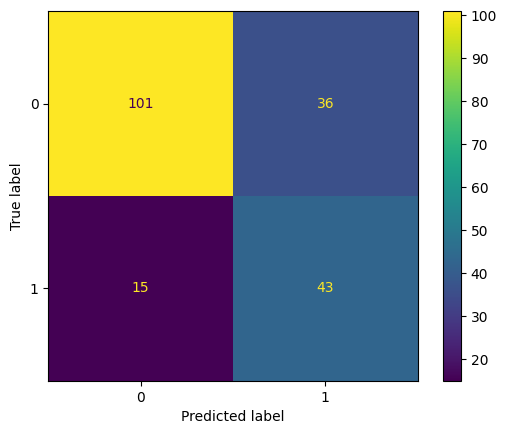

In [ ]:
confusion = confusion_matrix(true_y, predicted_labels)
ConfusionMatrixDisplay(confusion).plot()

In [ ]:
tn, fp, fn, tp = confusion.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ccr = (specificity+ sensitivity)/2
ppv = (tp / (tp + fp))
npv = (tn / (tn + fn))

print('sen:{}'.format(sensitivity))
print('spe:{}'.format(specificity))
print('CCR:{}'.format(ccr))
print('ppv:{}'.format(ppv))
print('nen:{}'.format(npv))

sen:0.7413793103448276
spe:0.7372262773722628
CCR:0.7393027938585452
ppv:0.5443037974683544
nen:0.8706896551724138


##Ten runs

In [ ]:
random_seed_list = [123, 80, 789, 567, 890, 345, 678, 901, 456, 12]

In [ ]:
def runs(random_seed_list, data):

  ccr_list = []
  sen_list = []
  spe_list = []
  ppv_list = []
  npv_list = []
  auc_list = []
  i = 1

  for seed in random_seed_list:

        train_df1, test_df1 = train_test_split(data, test_size=0.2, random_state = seed, stratify=data['labels'])
        train_df1, valid_df1 = train_test_split(train_df1, test_size=0.2, random_state = seed,  stratify=train_df1['labels'])

        train_df1 = train_df1.reset_index(drop=True)
        test_df1 = test_df1.reset_index(drop=True)

        #balance the traininng data
        majority_class = train_df1[train_df1['labels'] == 0]
        minority_class = train_df1[train_df1['labels'] == 1]
        majority_undersampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state = seed)
        train_df1 = pd.concat([minority_class, majority_undersampled])

        # preparing data for training
        PandasTools.AddMoleculeColumnToFrame(train_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
        PandasTools.AddMoleculeColumnToFrame(train_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
        moldf = train_df1[pd.notnull(train_df1['Mol'])]

        moldf['Descriptors'] = moldf.Mol.apply(calcfp)
        X = np.array(list(moldf['Descriptors'])).astype(int)
        y = moldf['labels'].to_numpy()

        traindata = Data(X, y)
        train_loader = DataLoader(traindata, batch_size=50, shuffle=True)

        # fit the model
        model1 = BinaryClassificationModel(num_units=2000)
        criterion = nn.BCELoss()
        optimizer = optim.SGD(model.parameters(), lr=0.1)
        training_epochs = 100

        train_model(model1, train_loader)

        # prepare evaluation dataevaluation
        PandasTools.AddMoleculeColumnToFrame(test_df1, smilesCol='smiles', molCol='Mol', includeFingerprints=False)
        test = test_df1[pd.notnull(test_df1['Mol'])]

        test['Descriptors'] = test.Mol.apply(calcfp)
        X_test = np.array(list(test['Descriptors'])).astype(int)
        y_test = test['labels'].to_numpy()

        #predict and evaluate
        model1.eval()

        X_test_tensor = torch.from_numpy(X_test).float()
        X_test_1 = X_test_tensor.to(device)

        # Perform inference on the entire test set


        with torch.no_grad():
            test_outputs = model(X_test_1)
            test_outputs = test_outputs.to(device)

        # Convert test_outputs to a numpy array
        test_res = test_outputs.cpu().numpy()
        predicted_labels = (test_res > 0.5).astype(int).flatten()

        predicted_labels=torch.from_numpy(predicted_labels)

        # Convert y_test to a numpy array
        true_labels = torch.from_numpy(y_test)
        true_y = true_labels.cpu()

        test_outputs = test_outputs.cpu().numpy()

        # Calculate evaluation metrics
        roc_auc = roc_auc_score(true_y, test_outputs)
        cm = confusion_matrix(true_y, predicted_labels)
        tn, fp, fn, tp = cm.ravel()

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        ccr = (specificity+ sensitivity)/2
        ppv = (tp / (tp + fp))
        npv = (tn / (tn + fn))

        ccr_list.append(ccr)
        sen_list.append(sensitivity)
        spe_list.append(specificity)
        ppv_list.append(ppv)
        npv_list.append(npv)
        auc_list.append(roc_auc)

        print('finished run:', i)
        i = i+1

  return ccr_list, sen_list, spe_list, ppv_list, npv_list, auc_list

In [ ]:
ccr_list, sen_list, spe_list, ppv_list, npv_list, auc_list = runs(random_seed_list, data)

Training finished
finished run: 1
Training finished
finished run: 2
Training finished
finished run: 3
Training finished
finished run: 4
Training finished
finished run: 5
Training finished
finished run: 6
Training finished
finished run: 7
Training finished
finished run: 8
Training finished
finished run: 9
Training finished
finished run: 10


In [ ]:
# Calculate mean and standard deviation
ccr_mean = np.mean(ccr_list)
ccr_std = np.std(ccr_list)

sen_mean = np.mean(sen_list)
sen_std = np.std(sen_list)

spe_mean = np.mean(spe_list)
spe_std = np.std(spe_list)

ppv_mean = np.mean(ppv_list)
ppv_std = np.std(ppv_list)

npv_mean = np.mean(npv_list)
npv_std = np.std(npv_list)

auc_mean = np.mean(auc_list)
auc_std = np.std(auc_list)

# Print the results
print(f'Mean and Standard Deviation of CCR: {ccr_mean:.2f} ± {ccr_std:.2f}')
print(f'Mean and Standard Deviation of Sensitivity: {sen_mean:.2f} ± {sen_std:.2f}')
print(f'Mean and Standard Deviation of Specificity: {spe_mean:.2f} ± {spe_std:.2f}')
print(f'Mean and Standard Deviation of PPV: {ppv_mean:.2f} ± {ppv_std:.2f}')
print(f'Mean and Standard Deviation of NPV: {npv_mean:.2f} ± {npv_std:.2f}')
print(f'Mean and Standard Deviation of AUC: {auc_mean:.2f} ± {auc_std:.2f}')

Mean and Standard Deviation of CCR: 0.86 ± 0.02
Mean and Standard Deviation of Sensitivity: 0.92 ± 0.03
Mean and Standard Deviation of Specificity: 0.81 ± 0.02
Mean and Standard Deviation of PPV: 0.67 ± 0.03
Mean and Standard Deviation of NPV: 0.96 ± 0.02
Mean and Standard Deviation of AUC: 0.94 ± 0.01
